In [6]:
using Pkg
using Convex
using SCS
using XLSX
using DataFrames
using Plots
using CSV
using Statistics
using Images
using DelimitedFiles

### 📈 Problem 1 Portfolio investment.
Our first problem will be an investment problem. We will look at stock prices from three companies and decide how to spend an amount of $1000 on these three companies. Let's first load some data.

In [8]:
function f(x,y,z)
    return x+y+z
end

l=[2,3,4]
f(l...)

9

In [14]:
T = DataFrame(XLSX.readtable("data/stock_prices.xlsx","Sheet2"))

Row,MSFT,FB,AAPL
,Any,Any,Any
1,101.93,137.95,148.26
2,102.8,143.8,152.29
3,107.71,150.04,156.82
4,107.17,149.01,157.76
5,102.78,165.71,166.52
6,105.67,167.33,170.41
7,108.22,162.5,170.42
8,110.97,161.89,172.97
9,112.53,162.28,174.97


`T` is a `DataFrame` that has weekly stock prices value of three companies (Microsoft, Facebook, Apple) from the period of January 2019 - March 2019. We will first take a quick look at these prices in a quick plot.

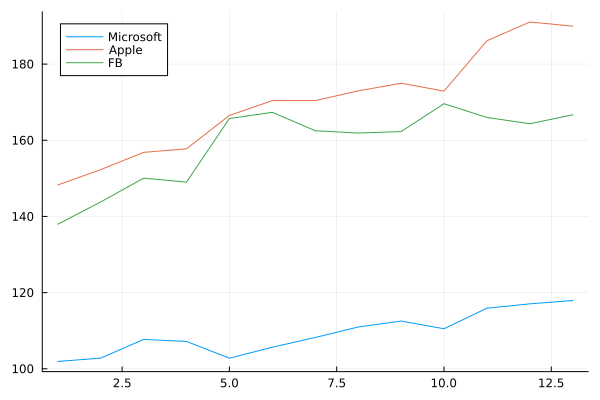

In [15]:
plot(T[!,:MSFT],label="Microsoft")
plot!(T[!,:AAPL],label="Apple")
plot!(T[!,:FB],label="FB")

In [16]:
# convert the prices to a Matrix to be used later in the optimization problem
prices_matrix = Matrix(T)

13×3 Matrix{Any}:
 101.93  137.95  148.26
 102.8   143.8   152.29
 107.71  150.04  156.82
 107.17  149.01  157.76
 102.78  165.71  166.52
 105.67  167.33  170.41
 108.22  162.5   170.42
 110.97  161.89  172.97
 112.53  162.28  174.97
 110.51  169.6   172.91
 115.91  165.98  186.12
 117.05  164.34  191.05
 117.94  166.69  189.95

To compute the weekly return, we will use the formula: `R[i,t] = (price[i,t] - price[i,t-1])/price[i,t-1]`. This is the return of stock `i` from week `t`.

In [17]:
M1 = prices_matrix[1:end-1,:]
M2 = prices_matrix[2:end,:]
R = (M2.-M1)./M1

12×3 Matrix{Float64}:
  0.00853527   0.0424067    0.027182
  0.0477626    0.0433936    0.0297459
 -0.00501346  -0.00686484   0.00599413
 -0.040963     0.112073     0.0555274
  0.0281183    0.00977611   0.0233606
  0.0241317   -0.0288651    5.8682e-5
  0.0254112   -0.00375385   0.014963
  0.0140579    0.00240904   0.0115627
 -0.0179508    0.0451072   -0.0117734
  0.0488644   -0.0213443    0.0763981
  0.00983522  -0.00988071   0.0264883
  0.00760359   0.0142996   -0.00575766

Now let's assume that the vector `x = [x1 x2 x3]` will contain the total number of dollars we will invest in these companies, i.e. `x1` is how much we will invest in the first company (MSFT), `x2` is how much we will invest in FB, and `x3` is how much we will invest in `AAPL`. The return on the investment will be `dot(r,x)`, where `r = [r1 r2 r3]` is the return from each of the companies.

Here, `r` is a random variable and we will have to model it in terms of expected values. And the expected value `E(dot(r,x))` will be `E[dot(mean(R,dims=2),x)`. If we want a return of `10%` or more, then we need `dot(r,x) >= 0.1`.

Next, we will model the risk matrix. We will skip the derivation of the risk matrix here, but you can read about it here: https://www.kdnuggets.com/2019/06/optimization-python-money-risk.html. The risk matrix will be the covariance matrix of the computed return prices (`R`).

In [18]:
risk_matrix = cov(R)

3×3 Matrix{Float64}:
  0.000659383  -0.000630653  0.000139112
 -0.000630653   0.00152162   0.000192288
  0.000139112   0.000192288  0.000635503

In [19]:
# note that the risk matrix is positive definite
isposdef(risk_matrix)

true

In [20]:
r = mean(R,dims=1)[:]

3-element Vector{Float64}:
 0.012532748705136572
 0.016563036855293173
 0.02114580465503291

Now let's solve the following problem: Someone gives you $1000 and tells you to spend them in the form of investment on these three compnaies such that you get a return of 2\% on what you spent.

The goal will be to minimize the risk, that is x'\*risk_matrix\*x.
The constraints will be 
- `sum(x) = 1`, we will compute the percentage of investment rather than the exact amount
- `dot(r,x) >= 0.02`
- `x[i] >= 0`

This problem is a convext problem, and we will use `Convex.jl` to it.

In [21]:
x = Variable(length(r))
problem = minimize(x'*risk_matrix*x,[sum(x)==1;r'*x>=0.02;x.>=0])

Problem statistics
  problem is DCP         : false
  number of variables    : 1 (3 scalar elements)
  number of constraints  : 5 (5 scalar elements)
  number of coefficients : 20
  number of atoms        : 15

Solution summary
  termination status : OPTIMIZE_NOT_CALLED
  primal status      : NO_SOLUTION
  dual status        : NO_SOLUTION

Expression graph
  minimize
   └─ * (Convex.NotDcp; real)
      ├─ * (affine; real)
      │  ├─ reshape (affine; real)
      │  │  └─ …
      │  └─ 3×3 Matrix{Float64}
      └─ 3-element real variable (id: 875…348)
  subject to
   ├─ == constraint (affine)
   │  └─ + (affine; real)
   │     ├─ sum (affine; real)
   │     │  └─ …
   │     └─ [-1;;]
   ├─ ≥ constraint (affine)
   │  └─ + (affine; real)
   │     ├─ * (affine; real)
   │     │  ├─ …
   │     │  └─ …
   │     └─ [-0.02;;]
   ├─ ≥ constraint (affine)
   │  └─ + (affine; real)
   │     ├─ index (affine; real)
   │     │  └─ …
   │     └─ [0;;]
   ⋮


Note the `Convex.NotDcp` in the answer above and the warning. `Convex.jl` requires that we pass Dcp compliant problem (Disciplined convex programming). Learn more about the DCP ruleset here: http://cvxr.com/cvx/doc/dcp.html

In [22]:
# make the problem DCP compliant
problem = minimize(Convex.quadform(x,risk_matrix),[sum(x)==1;r'*x>=0.02;x.>=0])

Problem statistics
  problem is DCP         : true
  number of variables    : 1 (3 scalar elements)
  number of constraints  : 5 (5 scalar elements)
  number of coefficients : 19
  number of atoms        : 14

Solution summary
  termination status : OPTIMIZE_NOT_CALLED
  primal status      : NO_SOLUTION
  dual status        : NO_SOLUTION

Expression graph
  minimize
   └─ * (convex; positive)
      ├─ [1;;]
      └─ qol_elem (convex; positive)
         ├─ norm2 (convex; positive)
         │  └─ …
         └─ [1.0;;]
  subject to
   ├─ == constraint (affine)
   │  └─ + (affine; real)
   │     ├─ sum (affine; real)
   │     │  └─ …
   │     └─ [-1;;]
   ├─ ≥ constraint (affine)
   │  └─ + (affine; real)
   │     ├─ * (affine; real)
   │     │  ├─ …
   │     │  └─ …
   │     └─ [-0.02;;]
   ├─ ≥ constraint (affine)
   │  └─ + (affine; real)
   │     ├─ index (affine; real)
   │     │  └─ …
   │     └─ [0;;]
   ⋮


In [23]:
solve!(problem, SCS.Optimizer)

┌ Info: [Convex.jl] Compilation finished: 10.47 seconds, 1.131 GiB of memory allocated
└ @ Convex /home/adrian/.julia/packages/Convex/QKz6m/src/solution.jl:107


------------------------------------------------------------------
	       SCS v3.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 5, constraints m: 12
cones: 	  z: primal zero / dual free vars: 1
	  l: linear vars: 4
	  q: soc vars: 7, qsize: 2
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
	  compiled with openmp parallelization enabled
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 22, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 1.45e+01  1.00e+00  2.01e+01 -9.96e+00  1.00e-01  5.27e-04 
    75| 1.70e-04  3.73e-05  5.25

Problem statistics
  problem is DCP         : true
  number of variables    : 1 (3 scalar elements)
  number of constraints  : 5 (5 scalar elements)
  number of coefficients : 19
  number of atoms        : 14

Solution summary
  termination status : OPTIMAL
  primal status      : FEASIBLE_POINT
  dual status        : FEASIBLE_POINT
  objective value    : 0.0005

Expression graph
  minimize
   └─ * (convex; positive)
      ├─ [1;;]
      └─ qol_elem (convex; positive)
         ├─ norm2 (convex; positive)
         │  └─ …
         └─ [1.0;;]
  subject to
   ├─ == constraint (affine)
   │  └─ + (affine; real)
   │     ├─ sum (affine; real)
   │     │  └─ …
   │     └─ [-1;;]
   ├─ ≥ constraint (affine)
   │  └─ + (affine; real)
   │     ├─ * (affine; real)
   │     │  ├─ …
   │     │  └─ …
   │     └─ [-0.02;;]
   ├─ ≥ constraint (affine)
   │  └─ + (affine; real)
   │     ├─ index (affine; real)
   │     │  └─ …
   │     └─ [0;;]
   ⋮


In [24]:
x

Variable
size: (3, 1)
sign: real
vexity: affine
id: 875…348
value: [0.07740709795030894, 0.11606771003983808, 0.8065276266877969]

In [25]:
sum(x.value)

1.000002434677944

In [26]:
# return 
r'*x.value 

1×1 adjoint(::Vector{Float64}) with eltype Float64:
 0.019947233108531894

In [27]:
x.value .* 1000

3×1 Matrix{Float64}:
  77.40709795030894
 116.06771003983808
 806.5276266877969

The conclusion is that we should invest **67.9USD in Microsoft**, **122.3USD in Facebook**, and **809.7USD in Apple**.

---
### 🖼️ Problem 2 Image recovery.
In this problem, we are given an image where some of the pixels have been altered. The goal is to recover the unknonwn pixels by solving an optimization problem. Let's first load the figure.

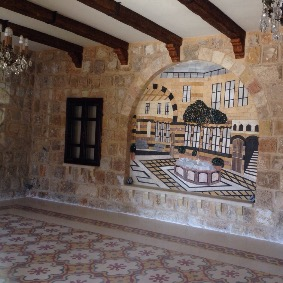

In [28]:
Kref = load("data/khiam-small.jpg")

We will convert the image to gray scale and disrupt some of the pixels

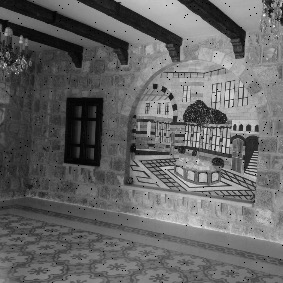

In [29]:
K = copy(Kref)
p = prod(size(K))
missingids = rand(1:p,400)
K[missingids] .= RGBX{N0f8}(0.0,0.0,0.0)
K
Gray.(K)

In [30]:
Y = Float64.(Gray.(K));

Given this image, the goal is now to complete the matrix. We will use a common technique for this problem developed by Candes and Tao. The goal will be to create a new matrix `X` where we minimize the nuclear norm of `X` (i.e. the sum of the singular values of `X`), and such that the entries that are already known in `Y` remain the same in `X`. We will again use `Convex.jl` to solve this problem. Let's write it down below.

In [31]:
correctids = findall(Y[:].!=0)
X = Convex.Variable(size(Y))
problem = minimize(nuclearnorm(X))
problem.constraints += X[correctids]==Y[correctids]

┌ Warning: Concatenating collections of constraints together with `+` or `+=` to produce a new list of constraints is deprecated. Instead, use `vcat` to concatenate collections of constraints.
└ @ Convex /home/adrian/.julia/packages/Convex/QKz6m/src/deprecations.jl:129


1-element Vector{Constraint}:
 == constraint (affine)
└─ + (affine; real)
   ├─ index (affine; real)
   │  └─ 283×283 real variable (id: 635…849)
   └─ 79690×1 Matrix{Float64}

In [32]:
solve!(problem, SCS.Optimizer(eps=1e-3, alpha=1.5))

MethodError: MethodError: no method matching SCS.Optimizer(; eps::Float64, alpha::Float64)
This method may not support any kwargs.

Closest candidates are:
  SCS.Optimizer() got unsupported keyword arguments "eps", "alpha"
   @ SCS ~/.julia/packages/SCS/Xusub/src/MOI_wrapper/MOI_wrapper.jl:131


In [33]:
@show norm(float.(Gray.(Kref))-X.value)
@show norm(-X.value)
colorview(Gray, X.value)

MethodError: MethodError: no method matching -(::Matrix{Gray{Float32}}, ::Nothing)
The function `-` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  -(!Matched::ChainRulesCore.ZeroTangent, ::Any)
   @ ChainRulesCore ~/.julia/packages/ChainRulesCore/6Pucz/src/tangent_arithmetic.jl:101
  -(::Any, !Matched::ChainRulesCore.NotImplemented)
   @ ChainRulesCore ~/.julia/packages/ChainRulesCore/6Pucz/src/tangent_arithmetic.jl:50
  -(!Matched::MutableArithmetics.Zero, ::Any)
   @ MutableArithmetics ~/.julia/packages/MutableArithmetics/sjjl8/src/rewrite.jl:67
  ...


In [34]:
@show norm(float.(Gray.(Kref))-X.value)
@show norm(-X.value)
colorview(Gray, X.value)

MethodError: MethodError: no method matching -(::Matrix{Gray{Float32}}, ::Nothing)
The function `-` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  -(!Matched::ChainRulesCore.ZeroTangent, ::Any)
   @ ChainRulesCore ~/.julia/packages/ChainRulesCore/6Pucz/src/tangent_arithmetic.jl:101
  -(::Any, !Matched::ChainRulesCore.NotImplemented)
   @ ChainRulesCore ~/.julia/packages/ChainRulesCore/6Pucz/src/tangent_arithmetic.jl:50
  -(!Matched::MutableArithmetics.Zero, ::Any)
   @ MutableArithmetics ~/.julia/packages/MutableArithmetics/sjjl8/src/rewrite.jl:67
  ...


---
### 🥒 Problem 3 Diet optimization problem.
This is a common problem in Numerical Optimization, and you can find multiple references about it online. Here, we will use one of the examples in the JuMP package. Refer to this page for details: https://github.com/JuliaOpt/JuMP.jl/blob/master/examples/diet.jl.

In this porblem we are given constraints on the number of (minimum, maximum) number of calories, protein, fat, and sodium to consume. We will first build a JuMP container to store this information and pass it as constraints later.

In [36]:
using JuMP
using GLPK

In [37]:
category_data = JuMP.Containers.DenseAxisArray(
    [1800 2200;
     91   Inf;
     0    65;
     0    1779], 
    ["calories", "protein", "fat", "sodium"], 
    ["min", "max"])

2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, ["calories", "protein", "fat", "sodium"]
    Dimension 2, ["min", "max"]
And data, a 4×2 Matrix{Float64}:
 1800.0  2200.0
   91.0    Inf
    0.0    65.0
    0.0  1779.0

You can think of this matrix as indexed by rows via the vector `["calories", "protein", "fat", "sodium"]`, and indexed by columns via the vector `["min", "max"]`. In fact, we can now checkout the values: `category_data["calories","max"]` or `category_data["fat","min"]`.

In [38]:
@show category_data["calories","max"] 
@show category_data["fat","min"]
;

category_data["calories", "max"] = 2200.0
category_data["fat", "min"] = 0.0


Next, we will encode some information about food data we have.

In [39]:
foods = ["hamburger", "chicken", "hot dog", "fries", "macaroni", "pizza","salad", "milk", "ice cream"]

# we will use the same concept we used above to create an array indexed 
# by foods this time to record the cost of each of these items
cost = JuMP.Containers.DenseAxisArray(
    [2.49, 2.89, 1.50, 1.89, 2.09, 1.99, 2.49, 0.89, 1.59],
    foods)

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, ["hamburger", "chicken", "hot dog", "fries", "macaroni", "pizza", "salad", "milk", "ice cream"]
And data, a 9-element Vector{Float64}:
 2.49
 2.89
 1.5
 1.89
 2.09
 1.99
 2.49
 0.89
 1.59

Next we will create a new matrix to encode the calories,protein, fat, and sodium present in each of these foods. This will be a matrix encoded by foods by rows, and `["calories", "protein", "fat", "sodium"]` by columns.

In [40]:
food_data = JuMP.Containers.DenseAxisArray(
    [410 24 26 730;
     420 32 10 1190;
     560 20 32 1800;
     380  4 19 270;
     320 12 10 930;
     320 15 12 820;
     320 31 12 1230;
     100  8 2.5 125;
     330  8 10 180], 
    foods, 
    ["calories", "protein", "fat", "sodium"])

@show food_data["chicken", "fat"]
@show food_data["milk", "sodium"]
;

food_data["chicken", "fat"] = 10.0
food_data["milk", "sodium"] = 125.0


And now, we will build the model.

In [41]:
# set up the model
model = Model(GLPK.Optimizer)

categories = ["calories", "protein", "fat", "sodium"]

# add the variables
@variables(model, begin
    # Variables for nutrition info
    category_data[c, "min"] <= nutrition[c = categories] <= category_data[c, "max"]
    # Variables for which foods to buy
    buy[foods] >= 0
end)

# Objective - minimize cost
@objective(model, Min, sum(cost[f] * buy[f] for f in foods))

# Nutrition constraints
@constraint(model, [c in categories],
    sum(food_data[f, c] * buy[f] for f in foods) == nutrition[c]
)

1-dimensional DenseAxisArray{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape},1,...} with index sets:
    Dimension 1, ["calories", "protein", "fat", "sodium"]
And data, a 4-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape}}:
 -nutrition[calories] + 410 buy[hamburger] + 420 buy[chicken] + 560 buy[hot dog] + 380 buy[fries] + 320 buy[macaroni] + 320 buy[pizza] + 320 buy[salad] + 100 buy[milk] + 330 buy[ice cream] = 0
 -nutrition[protein] + 24 buy[hamburger] + 32 buy[chicken] + 20 buy[hot dog] + 4 buy[fries] + 12 buy[macaroni] + 15 buy[pizza] + 31 buy[salad] + 8 buy[milk] + 8 buy[ice cream] = 0
 -nutrition[fat] + 26 buy[hamburger] + 10 buy[chicken] + 32 buy[hot dog] + 19 buy[fries] + 10 buy[macaroni] + 12 buy[pizza] + 12 buy[salad] + 2.5 buy[milk] + 10 buy[ice cream] = 0
 -n

And finally, all what's left to be done is to solve the problem

In [42]:
JuMP.optimize!(model)
term_status = JuMP.termination_status(model)
is_optimal = term_status == MOI.OPTIMAL
@show JuMP.primal_status(model) == MOI.FEASIBLE_POINT
@show JuMP.objective_value(model) ≈ 11.8288 atol = 1e-4

JuMP.primal_status(model) == MOI.FEASIBLE_POINT = true
JuMP.objective_value(model) ≈ 11.8288 = false
atol = 0.0001 = 0.0001


0.0001

And to actually look at the solution, we can look at the `buy` variable.

In [43]:
hcat(buy.data,JuMP.value.(buy.data))

9×2 Matrix{AffExpr}:
 buy[hamburger]  0.6045138888888888
 buy[chicken]    0
 buy[hot dog]    0
 buy[fries]      0
 buy[macaroni]   0
 buy[pizza]      0
 buy[salad]      0
 buy[milk]       6.9701388888888935
 buy[ice cream]  2.591319444444441

----
### 🗺️ How many passports do you need to travel the world without obtaining a visa in advance?
This problem is the same problem shown in the JuliaCon 2018 JuMP workshop, with updated code and data. The original post can be found here: https://github.com/juan-pablo-vielma/JuliaCon2018_JuMP_Workshop/blob/master/Introduction_Slides.ipynb.

We will first get the data.

In [45]:
#;git clone https://github.com/ilyankou/passport-index-dataset.git

The file we need is `passport-index-dataset/passport-index-matrix.csv`, and we will use the `DelimitedFiles` package to read it -- this is mainly because what we are loading is a matrix and we will have to extract the matrix out of the DataFrame if we use the `CSV` package. Both are viable options, this will just be quicker.

In [46]:
passportdata = readdlm(joinpath("passport-index-dataset","passport-index-matrix.csv"),',')

200×200 Matrix{Any}:
 "Passport"               "Albania"    "Algeria"        …    "Afghanistan"
 "Afghanistan"            "e-visa"     "visa required"     -1
 "Albania"              -1             "visa required"       "visa required"
 "Algeria"                "e-visa"   -1                      "visa required"
 "Andorra"              90             "visa required"       "visa required"
 "Angola"                 "e-visa"     "visa required"  …    "visa required"
 "Antigua and Barbuda"  90             "visa required"       "visa required"
 "Argentina"            90             "visa required"       "visa required"
 "Armenia"              90             "visa required"       "visa required"
 "Australia"            90             "visa required"       "visa required"
 ⋮                                                      ⋱  
 "Uruguay"              90             "visa required"       "visa required"
 "Uzbekistan"             "e-visa"     "visa required"       "visa required"
 "Vanuatu"  

These are the possible options in this matrix:

| Value | Explanation |
|---|---|
|7-360| number of visa-free days|
|VF| visa-free travel (where number of days is not applicable or known, eg freedom of movement)|
|VOA| visa on arrival|
|ETA| eTA (electronic travel authority) required|
|VR| visa required|
|-1| where passport=destination, in matrix files only|

So anything that is a number or "VF" or "VOA", can be entered without a visa in advance.

In [47]:
cntr = passportdata[2:end,1]
vf = (x ->  typeof(x)==Int64 || x == "VF" || x == "VOA" ? 1 : 0).(passportdata[2:end,2:end]);

Set up the model

In [48]:
model = Model(GLPK.Optimizer)

A JuMP Model
├ solver: GLPK
├ objective_sense: FEASIBILITY_SENSE
├ num_variables: 0
├ num_constraints: 0
└ Names registered in the model: none

Add the variables, constrains, and the objective function.

In [49]:
@variable(model, pass[1:length(cntr)], Bin)
@constraint(model, [j=1:length(cntr)], sum( vf[i,j]*pass[i] for i in 1:length(cntr)) >= 1)
@objective(model, Min, sum(pass))

pass[1] + pass[2] + pass[3] + pass[4] + pass[5] + pass[6] + pass[7] + pass[8] + pass[9] + pass[10] + pass[11] + pass[12] + pass[13] + pass[14] + pass[15] + pass[16] + pass[17] + pass[18] + pass[19] + pass[20] + pass[21] + pass[22] + pass[23] + pass[24] + pass[25] + pass[26] + pass[27] + pass[28] + pass[29] + pass[30] + [[...139 terms omitted...]] + pass[170] + pass[171] + pass[172] + pass[173] + pass[174] + pass[175] + pass[176] + pass[177] + pass[178] + pass[179] + pass[180] + pass[181] + pass[182] + pass[183] + pass[184] + pass[185] + pass[186] + pass[187] + pass[188] + pass[189] + pass[190] + pass[191] + pass[192] + pass[193] + pass[194] + pass[195] + pass[196] + pass[197] + pass[198] + pass[199]

And finally, solve the problem

In [50]:
JuMP.optimize!(model)

In [51]:
print(JuMP.objective_value(model)," passports: ",join(cntr[findall(JuMP.value.(pass) .== 1)],", "))

34.0 passports: Afghanistan, Australia, Bahrain, Cameroon, Comoros, Congo, Djibouti, Dominican Republic, Eritrea, Guinea-Bissau, Hong Kong, Iran, Kenya, Kuwait, Liberia, Libya, Madagascar, Maldives, Mauritania, Morocco, Nepal, New Zealand, North Korea, Palestine, Papua New Guinea, Qatar, Saudi Arabia, Singapore, Somalia, South Sudan, Spain, Syria, Turkmenistan, United States

# Finally...
After finishing this notebook, you should be able to:
- [ ] solve optimization problems via the Convex.jl package
- [ ] solve optimization problems via the JuMP.jl package

# 🥳 One cool finding

We found out that you need at least 21 passports to tour the world visa free. Here is one solutions we found:

`Afghanistan, Austria, Comoros, Equatorial Guinea, Eritrea, Gambia, Georgia, Hong Kong, India, Iraq, Kenya, Madagascar, Maldives, North Korea, Papua New Guinea, Seychelles, Singapore, Somalia, Tunisia, United Arab Emirates, Zimbabwe`
